In [ ]:
!pip install fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.0/309.0 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.9 MB/s eta 0:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import numpy as np
from skimage.color import rgb2lab, lab2rgb
import torch.nn.functional as F
from torchvision import datasets
import os
import fiftyone
import fiftyone.zoo as foz
from PIL import Image
from skimage import color
import json
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio as ski_psnr
from skimage.color import lab2rgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
JSON_PATH = "/content/drive/MyDrive/coco_train_image_paths.json"
COCO_DIR  = "/content/drive/MyDrive/COCO_2017"

os.makedirs(COCO_DIR, exist_ok=True)


def rebuild_and_save_coco_paths():
    print("Downloading COCO train split into Google Drive...")

    dataset = fiftyone.zoo.load_zoo_dataset(
    "coco-2017",
    split="train",
    dataset_dir=COCO_DIR,
    overwrite=True)

    paths = dataset.values("filepath")

    print("Saving filepaths to Drive...")
    with open(JSON_PATH, "w") as f:
        json.dump(paths, f)

    print("Dataset rebuilt and saved.")
    return paths


def load_or_build_coco_paths():
    if os.path.exists(JSON_PATH):
        print("JSON found. Checking filepaths...")

        with open(JSON_PATH, "r") as f:
            paths = json.load(f)

        # Validate paths
        valid = [p for p in paths if os.path.exists(p)]
        print(f"Total in JSON: {len(paths)}, Valid: {len(valid)}")

        if len(valid) >= 0.95 * len(paths):
            print("Using cached dataset.")
            return valid

        print("Paths invalid: start rebuilding dataset")

    return rebuild_and_save_coco_paths()

image_paths = load_or_build_coco_paths()


JSON found. Checking filepaths...
Total in JSON: 118287, Valid: 118287
Using cached dataset.


In [ ]:
def compute_ab_weights_fast(image_paths, n_bins=20, epsilon=1e-6, save_file="ab_weights.json", sample_size=5000):
    """
    Computes AB rebalancing weights using a subset of images for speed.

    Args:
        image_paths (list): List of image file paths.
        n_bins (int): Number of bins per channel.
        epsilon (float): Small value to avoid division by zero.
        save_file (str): Path to save the weights JSON.
        sample_size (int): Number of images to sample for histogram.

    Returns:
        ab_weights (np.ndarray): Normalized AB rebalancing weights (n_bins x n_bins).
    """

    ab_hist = np.zeros((n_bins, n_bins), dtype=np.float32)

    # Randomly sample images
    if len(image_paths) > sample_size:
        sampled_paths = random.sample(image_paths, sample_size)
    else:
        sampled_paths = image_paths

    for idx, path in enumerate(sampled_paths):
        try:
            img = Image.open(path).convert("RGB")
            img = img.resize((128, 128))  # smaller size for faster processing
            img_np = np.array(img) / 255.0
            lab = color.rgb2lab(img_np)

            A = lab[:, :, 1]  # [-128, 127]
            B = lab[:, :, 2]

            # Convert to bins (discrete numbers)
            A_bin = ((A + 128) / 256 * n_bins).astype(int)
            B_bin = ((B + 128) / 256 * n_bins).astype(int)
            A_bin = np.clip(A_bin, 0, n_bins - 1)
            B_bin = np.clip(B_bin, 0, n_bins - 1)

            # histogram
            for a, b in zip(A_bin.flatten(), B_bin.flatten()):
                ab_hist[a, b] += 1

        except Exception as e:
            print(f"Error {path}: {e}")

        if idx % 500 == 0:
            print(f"Processed {idx}/{len(sampled_paths)} images")

    # Convert to probas
    ab_prob = ab_hist / ab_hist.sum()

    # Compute weights
    ab_weights = 1 / (ab_prob + epsilon)
    min_w, max_w = 0.5, 5.0 # we used to have 0-1 but it brought loss to 0
    ab_weights = ab_weights / ab_weights.max() * max_w
    ab_weights = torch.clamp(torch.tensor(ab_weights), min=min_w, max=max_w)

    # Save weights
    with open(save_file, "w") as f:
        json.dump(ab_weights.tolist(), f)

    print(f"Saved AB weights to {save_file}")
    return ab_weights

ab_weights = compute_ab_weights_fast(image_paths, sample_size=5000)


Processed 0/5000 images
Processed 500/5000 images
Processed 1000/5000 images
Processed 1500/5000 images
Processed 2000/5000 images
Processed 2500/5000 images
Processed 3000/5000 images
Processed 3500/5000 images
Processed 4000/5000 images
Processed 4500/5000 images
Saved AB weights to ab_weights.json


In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, image_paths, stats_file="/content/drive/MyDrive/ab_stats.json", weights_file="ab_weights.json", image_size=256):
        self.image_paths = image_paths
        self.image_size = image_size
        self.resize = transforms.Resize((image_size, image_size))

        # Load stats for normalizing data
        with open(stats_file, "r") as f:
            stats = json.load(f)
        self.ab_min = torch.tensor(stats["ab_min"]).float()
        self.ab_max = torch.tensor(stats["ab_max"]).float()

        # Load AB weights
        with open(weights_file, "r") as f:
            self.ab_weights = torch.tensor(json.load(f)).float()  # shape: (n_bins, n_bins)
        self.n_bins = self.ab_weights.shape[0]

    def normalize_ab(self, AB):
        AB_flat = AB.permute(1,2,0)
        AB_norm = (AB_flat - self.ab_min) / (self.ab_max - self.ab_min)
        AB_norm = AB_norm * 2 - 1
        return AB_norm.permute(2,0,1)

    def get_ab_weight_map(self, AB):
        A, B = AB[0], AB[1]  # shape (H,W)
        bin_idx_a = ((A + 128)/256 * self.n_bins).long().clamp(0, self.n_bins-1)
        bin_idx_b = ((B + 128)/256 * self.n_bins).long().clamp(0, self.n_bins-1)
        weight_map = self.ab_weights[bin_idx_a, bin_idx_b]
        return weight_map

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.resize(img)
        img = np.array(img)/255.0
        lab = color.rgb2lab(img)
        L = lab[:,:,0]
        A = lab[:,:,1]
        B = lab[:,:,2]

        L_norm = torch.tensor((L/50.0 -1.0)).float().unsqueeze(0)
        AB = torch.tensor(np.stack([A,B], axis=0)).float()
        AB_norm = self.normalize_ab(AB)

        # Weight map
        weight_map = self.get_ab_weight_map(AB)

        return L_norm, AB_norm, weight_map

    def __len__(self):
        return len(self.image_paths)


In [ ]:
IMAGE_TRAIN_DIR = '/content/drive/MyDrive/Color/'

train_dataset = ColorizationDataset(image_paths)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)


In [ ]:
stats = {
    "ab_min": train_dataset.ab_min.tolist(),
    "ab_max": train_dataset.ab_max.tolist()
}

with open("/content/drive/MyDrive/ab_stats.json", "w") as f:
    json.dump(stats, f)

print("Saved AB stats permanently to Drive!")


Saved AB stats permanently to Drive!


In [ ]:
train_dataset.ab_min, train_dataset.ab_max


(tensor([ -86.1830, -107.7841]), tensor([98.2331, 94.4781]))

In [ ]:
from sklearn.model_selection import train_test_split

train_paths, val_paths = train_test_split(image_paths, test_size=0.1, random_state=42)

train_dataset = ColorizationDataset(train_paths)
val_dataset = ColorizationDataset(val_paths)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)


In [ ]:
class FCNConvBlock(nn.Module):
    # This block can perform a standard Conv (stride=1) or a Downsampling Conv (stride=2)
    def __init__(self, in_c, out_c, stride=1, norm=True):
        super().__init__()
        # 3x3 kernel with padding=1 to keep dimensions equal when stride=1
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1)
        self.norm = nn.BatchNorm2d(out_c) if norm else nn.Identity()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))

class UpsampleBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        # Nearest-neighbor unsampling
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = FCNConvBlock(in_c, out_c, stride=1)

    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        return x

In [ ]:
class DeepFCNColorizationAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # 1 channel
        IN_C = 1

        #ENCODER (Contracting: 256 -> 16)

        # Level 1: 256x256 -> 128x128
        self.enc1 = FCNConvBlock(IN_C, 64, stride=1)
        self.down1 = FCNConvBlock(64, 128, stride=2)

        # Level 2: 128x128 -> 64x64
        self.enc2 = FCNConvBlock(128, 128, stride=1)
        self.down2 = FCNConvBlock(128, 256, stride=2)

        # Level 3: 64x64 -> 32x32
        self.enc3 = FCNConvBlock(256, 256, stride=1)
        self.down3 = FCNConvBlock(256, 512, stride=2)

        # Level 4: 32x32 -> 16x16
        self.enc4 = FCNConvBlock(512, 512, stride=1)

        # Bottleneck: 16x16x1024
        self.bottleneck = FCNConvBlock(512, 1024, stride=1)

        # DECODER (Expanding: 16 -> 256)

        # Level 4 Upsample: 16x16 -> 32x32. Skip connection from enc4 (512 channels)
        # Halve bottleneck channels: 1024 -> 512
        self.up4_prep = FCNConvBlock(1024, 512, stride=1)

        self.upsample4 = UpsampleBlock(512, 512)
        # Dec block input: 512 (up) + 512 (skip) = 1024
        self.dec4 = FCNConvBlock(512 + 512, 512)

        # Level 3 Upsample: 32x32 -> 64x64. Skip from enc3 (256 channels)
        self.upsample3 = UpsampleBlock(512, 256)
        # Dec block input: 256 (up) + 256 (skip) = 512
        self.dec3 = FCNConvBlock(256 + 256, 256)

        # Level 2 Upsample: 64x64 -> 128x128. Skip from enc2 (128 channels)
        self.upsample2 = UpsampleBlock(256, 128)
        # Dec block input: 128 (up) + 128 (skip) = 256
        self.dec2 = FCNConvBlock(128 + 128, 128)

        # Level 1 Upsample: 128x128 -> 256x256. Skip from enc1 (64 channels)
        self.upsample1 = UpsampleBlock(128, 64)
        # Dec block input: 64 (up) + 64 (skip) = 128
        self.dec1 = FCNConvBlock(64 + 64, 64)

        # Final Output Layer: 256x256x64 -> 256x256x2 (AB channels)
        self.final_conv = nn.Conv2d(64, 2, kernel_size=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # --- Encoder ---
        e1 = self.enc1(x)
        p1 = self.down1(e1)

        e2 = self.enc2(p1)
        p2 = self.down2(e2)

        e3 = self.enc3(p2)
        p3 = self.down3(e3)

        e4 = self.enc4(p3)

        b = self.bottleneck(e4)

        # --- Decoder ---

        # Level 4: 16 -> 32
        d4_prep = self.up4_prep(b)
        d4_up = self.upsample4(d4_prep)
        d4_up = F.interpolate(d4_up, size=e4.size()[2:], mode='nearest') # Ensure size match with e4
        d4 = torch.cat((d4_up, e4), dim=1)
        d4 = self.dec4(d4)

        # Level 3: 32 -> 64
        d3_up = self.upsample3(d4)
        d3_up = F.interpolate(d3_up, size=e3.size()[2:], mode='nearest') # Ensure size match with e3
        d3 = torch.cat((d3_up, e3), dim=1)
        d3 = self.dec3(d3)

        # Level 2: 64 -> 128
        d2_up = self.upsample2(d3)
        d2_up = F.interpolate(d2_up, size=e2.size()[2:], mode='nearest') # Ensure size match with e2
        d2 = torch.cat((d2_up, e2), dim=1)
        d2 = self.dec2(d2)

        # Level 1: 128 -> 256
        d1_up = self.upsample1(d2)
        d1_up = F.interpolate(d1_up, size=e1.size()[2:], mode='nearest') # Ensure size match with e1
        d1 = torch.cat((d1_up, e1), dim=1)
        d1 = self.dec1(d1)

        output = self.final_conv(d1)
        return self.tanh(output)

In [ ]:
def train_model(model, loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        for i, (L, AB_true, weight_map) in enumerate(loader):
            L, AB_true, weight_map = L.to(device), AB_true.to(device), weight_map.to(device)

            AB_pred = model(L)
            loss_map = criterion(AB_pred, AB_true) * weight_map.unsqueeze(1)
            loss = loss_map.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Log progress
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(loader)}], Loss: {loss.item():.4f}')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepFCNColorizationAutoencoder().to(device)

criterion = torch.nn.L1Loss(reduction="none")

optimizer = torch.optim.Adam(model.parameters(), lr=4e-4, betas=(0.5, 0.999))


In [ ]:
#train_model(model,train_loader, criterion, optimizer)
#We tried pretraining the generator to make it stronger but it didn't add anything

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/generator_weights.pth")
print("Weights saved")

Weights saved!


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # [H, W] -> [H/2, W/2]
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
#For CIFAR10 we had only 3 layers, we added new layers to capture increased complexity with COCO dataset
        self.layer4_new = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
#we tried with and without a 5th layer, but the 5th layer made it too strong
        #self.layer5_deep = nn.Sequential(
        #    nn.Conv2d(512, 512, kernel_size=4, stride=1, padding=1),
        #    nn.BatchNorm2d(512),
        #    nn.LeakyReLU(0.2, inplace=True)
        #)
        self.final_conv = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, img_lab):

        x = self.layer1(img_lab) # Output: 128x128x64
        x = self.layer2(x)      # Output: 64x64x128
        x = self.layer3(x)      # Output: 32x32x256
        x = self.layer4_new(x)  # Output: 16x16x512
        #x = self.layer5_deep(x)
        output = self.final_conv(x) # Output: 16x16x1 (Probability Map)

        return output

In [ ]:
discriminator = Discriminator().to(device)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999))

criterion_G_reconstruction = nn.L1Loss()


In [ ]:
def train_gan(
    generator, discriminator, loader, val_loader,
    criterion_recon, optim_G, optim_D,
    device, num_epochs=10
):
    real_label = 0.8
    fake_label = 0.2
    criterion_adv = nn.BCEWithLogitsLoss()
    BEST_PSNR = -float("inf")
    lambda_recon = 70

    for epoch in range(num_epochs):
        for i, (L, AB_true, weight_map) in enumerate(loader):
            L, AB_true, weight_map = L.to(device), AB_true.to(device), weight_map.to(device)

            batch_size = L.size(0)

            # Discriminator
            optim_D.zero_grad()

            # Real images
            real_images = torch.cat((L, AB_true), dim=1)
            D_real = discriminator(real_images)
            labels_real = torch.full(D_real.shape, real_label, device=device)
            loss_D_real = criterion_adv(D_real, labels_real)

            # Fake images
            with torch.no_grad():
                AB_fake = generator(L)
            fake_images = torch.cat((L, AB_fake), dim=1)
            D_fake = discriminator(fake_images)
            labels_fake = torch.full(D_fake.shape, fake_label, device=device)
            loss_D_fake = criterion_adv(D_fake, labels_fake)

            loss_D = (loss_D_real + loss_D_fake) * 0.5
            loss_D.backward()
            optim_D.step()

            # Generator
            optim_G.zero_grad()

            AB_fake = generator(L)
            fake_images_G = torch.cat((L, AB_fake), dim=1)
            D_G = discriminator(fake_images_G)
            labels_G = torch.full(D_G.shape, real_label, device=device)
            loss_G_adv = criterion_adv(D_G, labels_G)
            loss_G_recon = (criterion_recon(AB_fake, AB_true) * weight_map.unsqueeze(1)).mean()
            loss_G = loss_G_adv + lambda_recon * loss_G_recon
            loss_G.backward()
            optim_G.step()

            # Log
            if i % 500 == 0:
                print(
                    f"[{epoch+1}/{num_epochs}][{i}/{len(loader)}] "
                    f"Loss_D: {loss_D.item():.4f} "
                    f"Loss_G: {loss_G.item():.4f} "
                    f"(Adv: {loss_G_adv.item():.4f}, Recon: {loss_G_recon.item():.4f})"
                )

        # Validation
        avg_psnr = evaluate_model(generator, val_loader, device)
        print(f"Epoch {epoch+1} | Validation PSNR: {avg_psnr:.4f}")

        if avg_psnr > BEST_PSNR:
            BEST_PSNR = avg_psnr
            torch.save(generator.state_dict(), 'best_generator_psnr.pth')
            print(f"Saved new best model: PSNR = {BEST_PSNR:.4f}")

        if avg_psnr > BEST_PSNR:
            BEST_PSNR = avg_psnr
            checkpoint = {
                "epoch": epoch,
                "generator": generator.state_dict(),
                "discriminator": discriminator.state_dict(),
                "optim_G": optim_G.state_dict(),
                "optim_D": optim_D.state_dict(),
                "best_psnr": BEST_PSNR
            }
            torch.save(checkpoint, "best_checkpoint.pth")
            print("Saved BEST model.")


In [ ]:
def calculate_psnr(L_input, AB_pred, AB_true):
    """
    Calculates the average PSNR for a batch of images.

    Args:
        L_input (torch.Tensor): The grayscale L channel (e.g., [B, 1, H, W]).
        AB_pred (torch.Tensor): The predicted A and B channels (e.g., [B, 2, H, W]).
        AB_true (torch.Tensor): The ground truth A and B channels (e.g., [B, 2, H, W]).

    Returns:
        float: The average PSNR across the batch.
    """
    L_np = L_input.detach().cpu().numpy()
    AB_pred_np = AB_pred.detach().cpu().numpy()
    AB_true_np = AB_true.detach().cpu().numpy()

    psnr_values = []

    # Iterate through each image in the batch
    for i in range(L_np.shape[0]):
        # Denormalize L channel from [-1, 1] back to [0, 100]
        L_denorm = (L_np[i, 0] + 1.0) * 50.0

        # Denormalize AB channels from [-1, 1] back to [-128, 127]
        AB_pred_denorm = np.transpose(AB_pred_np[i], (1, 2, 0)) * 128.0
        AB_true_denorm = np.transpose(AB_true_np[i], (1, 2, 0)) * 128.0

        # Combine L and AB to form the full LAB image (H, W, 3)
        LAB_pred = np.concatenate((L_denorm[:, :, np.newaxis], AB_pred_denorm), axis=2)
        LAB_true = np.concatenate((L_denorm[:, :, np.newaxis], AB_true_denorm), axis=2)

        # Convert to RGB for PSNR
        # lab2rgb assumes the L channel is [0, 100] (which it is)
        RGB_pred = lab2rgb(LAB_pred)
        RGB_true = lab2rgb(LAB_true)

        # Calculate PSNR
        psnr_val = ski_psnr(RGB_true, RGB_pred, data_range=1.0)
        psnr_values.append(psnr_val)

    return np.mean(psnr_values)

In [ ]:
def evaluate_model(generator, val_loader, device):
    generator.eval()
    total_psnr = 0.0
    num_batches = 0

    with torch.no_grad():
        for L, AB_true, weight_map in val_loader:
            L, AB_true = L.to(device), AB_true.to(device)
            AB_pred = generator(L)

            psnr_batch = calculate_psnr(L, AB_pred, AB_true)

            total_psnr += psnr_batch
            num_batches += 1

    generator.train()
    return total_psnr / num_batches

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/GANcheckpoint.pth", map_location=device)

model.load_state_dict(checkpoint["generator"])
discriminator.load_state_dict(checkpoint["discriminator"])

optimizer.load_state_dict(checkpoint["optim_G"])
optimizer_D.load_state_dict(checkpoint["optim_D"])

start_epoch = checkpoint["epoch"] + 1
BEST_PSNR = checkpoint["best_psnr"]

remaining_epochs = 60 - start_epoch




In [ ]:
train_gan(
    generator=model,
    discriminator=discriminator,
    loader=train_loader,
    val_loader=val_loader,
    criterion_recon=criterion_G_reconstruction,
    optim_G=optimizer,
    optim_D=optimizer_D,
    device=device,
    num_epochs=60
)


In [ ]:
def visualize_gan_output(generator, dataset, device, idx=0):
    """
    Visualizes:
      - Input grayscale L (model input)
      - Ground truth color
      - Generated GAN color
    """

    generator.eval()

    L, AB_true, _ = dataset[idx]
    L = L.unsqueeze(0).to(device)             # (1,1,H,W)
    AB_true = AB_true.unsqueeze(0).to(device) # (1,2,H,W)

    with torch.no_grad():
        AB_fake = generator(L)

    L_np = (L[0,0].cpu().numpy() * 100)   # L scaled to [0,100]
    AB_true_np = (AB_true[0].permute(1,2,0).cpu().numpy() * 128)
    AB_fake_np = (AB_fake[0].permute(1,2,0).cpu().numpy() * 128)

    lab_true = np.stack([L_np, AB_true_np[...,0], AB_true_np[...,1]], axis=-1)
    lab_fake = np.stack([L_np, AB_fake_np[...,0], AB_fake_np[...,1]], axis=-1)

    rgb_true = lab2rgb(lab_true)
    rgb_fake = lab2rgb(lab_fake)

    plt.figure(figsize=(14, 5))

    # Grayscale L
    plt.subplot(1, 3, 1)
    plt.title("Input L (Grayscale)")
    plt.imshow(L_np, cmap='gray')
    plt.axis("off")

    # Ground truth color
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(rgb_true)
    plt.axis("off")

    # GAN output
    plt.subplot(1, 3, 3)
    plt.title("GAN Generated Color")
    plt.imshow(rgb_fake)
    plt.axis("off")

    plt.show()


/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 40973 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 42033 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


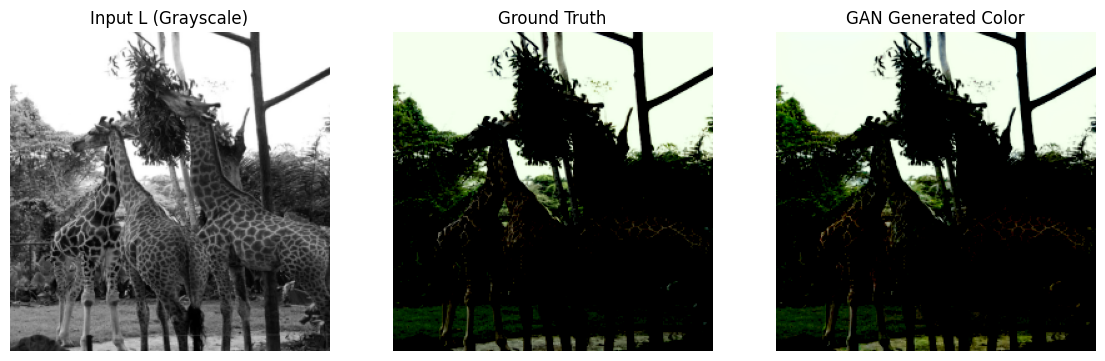

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 19997 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 10234 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


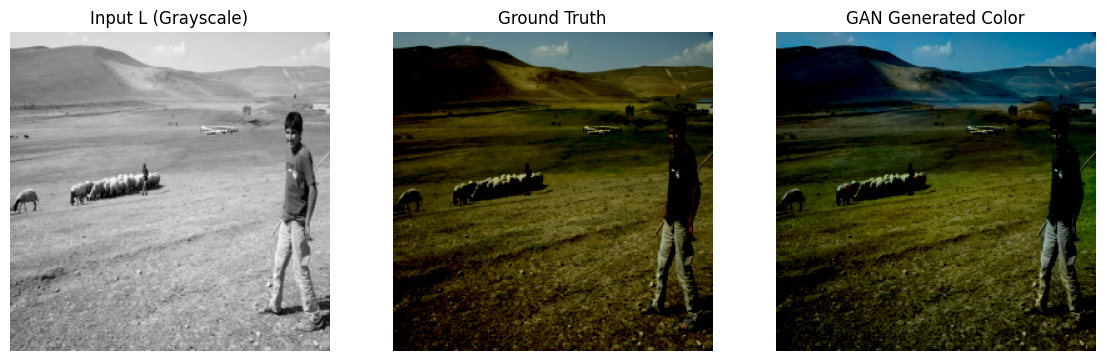

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 30264 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 34215 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


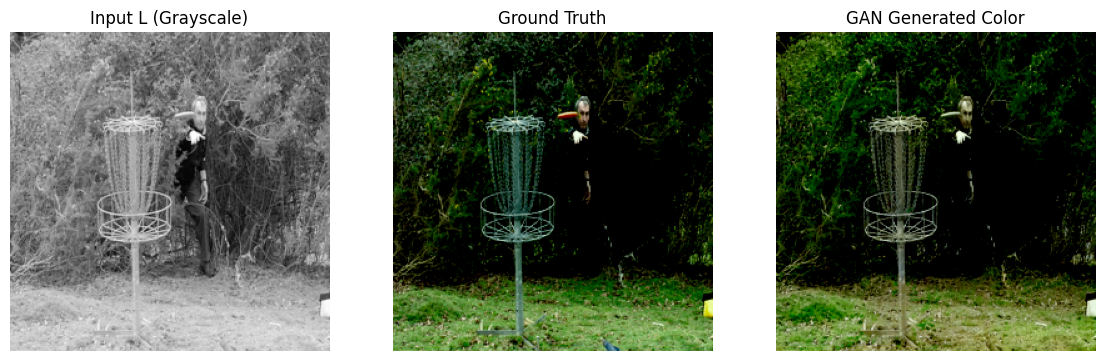

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 30991 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 27267 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


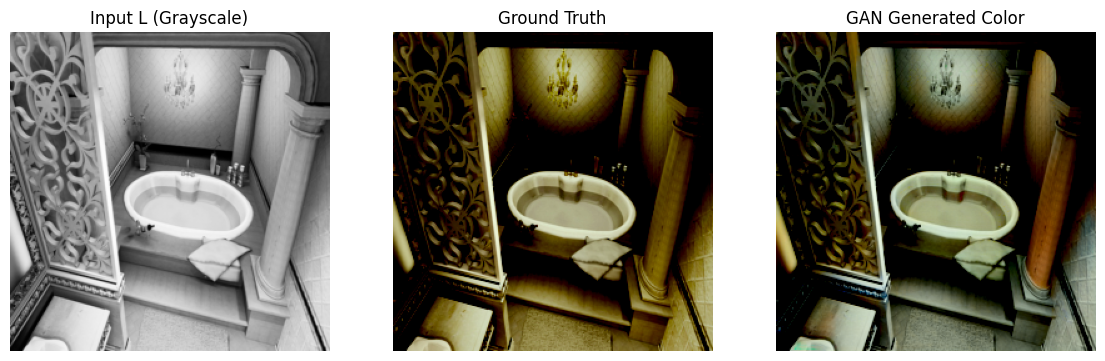

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 36714 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 35715 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


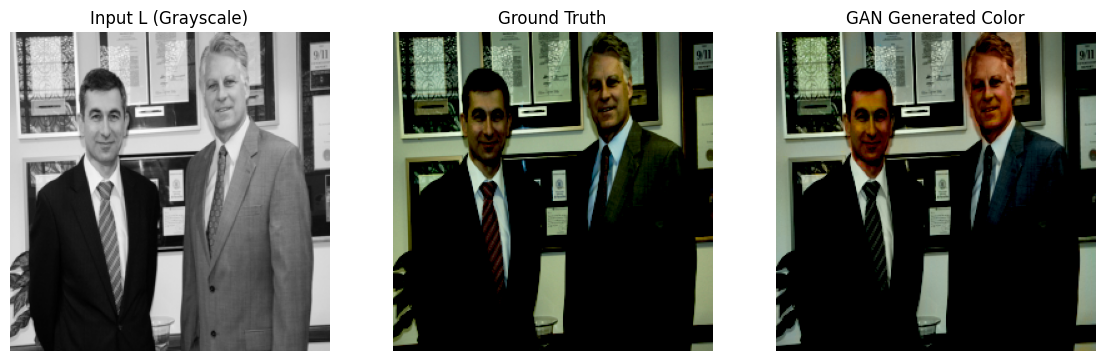

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 64887 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 62728 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


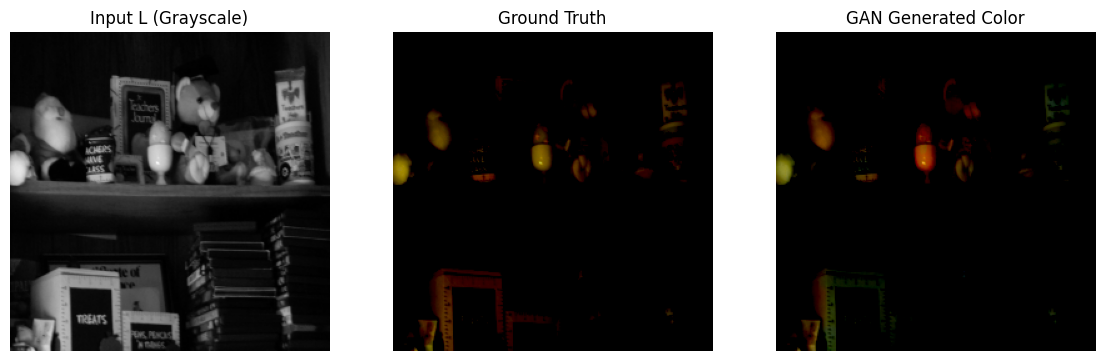

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 50289 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 50067 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


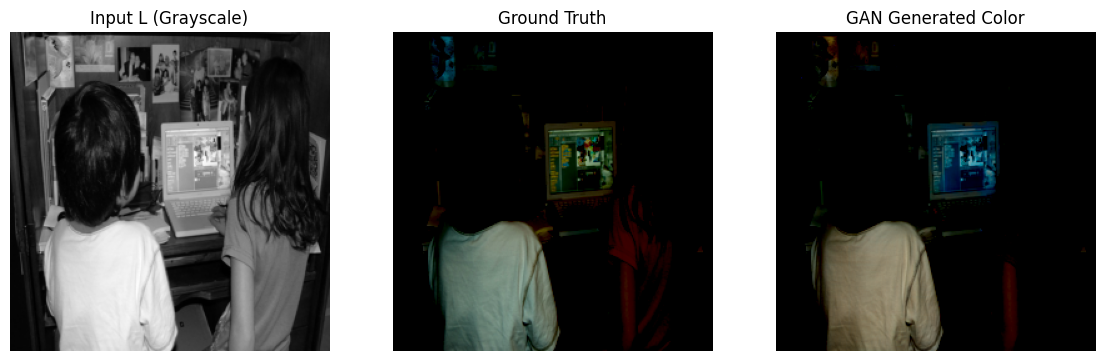

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 37957 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 33492 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


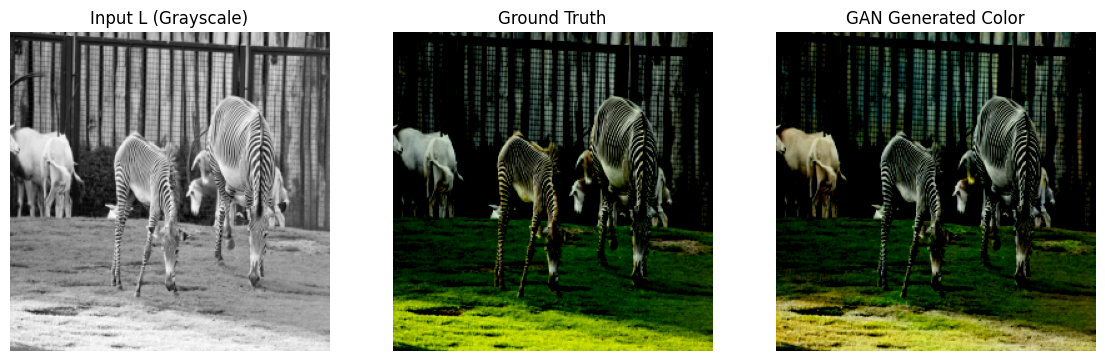

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 23033 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 20026 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


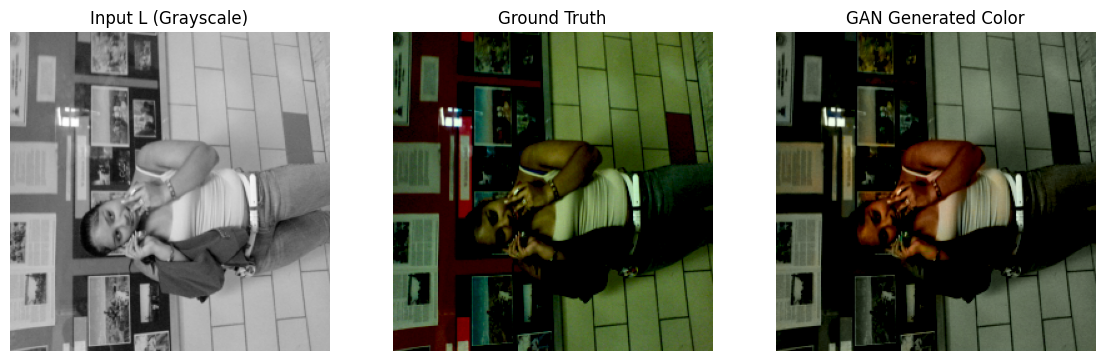

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 45933 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 48918 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


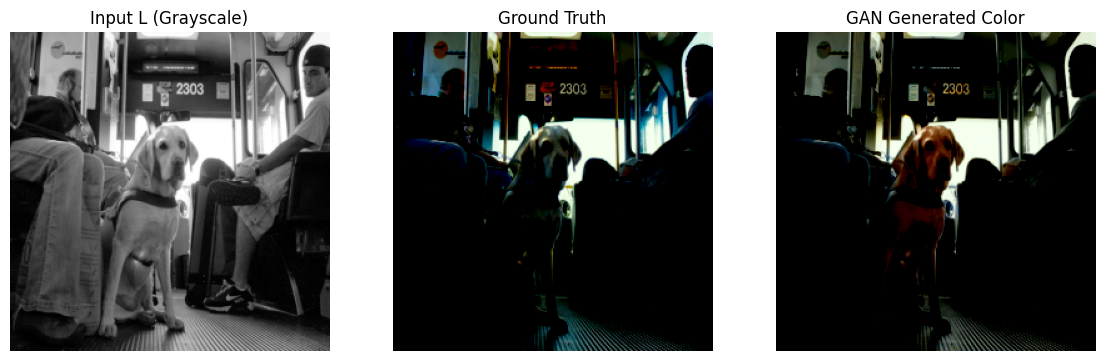

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 40855 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 42140 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


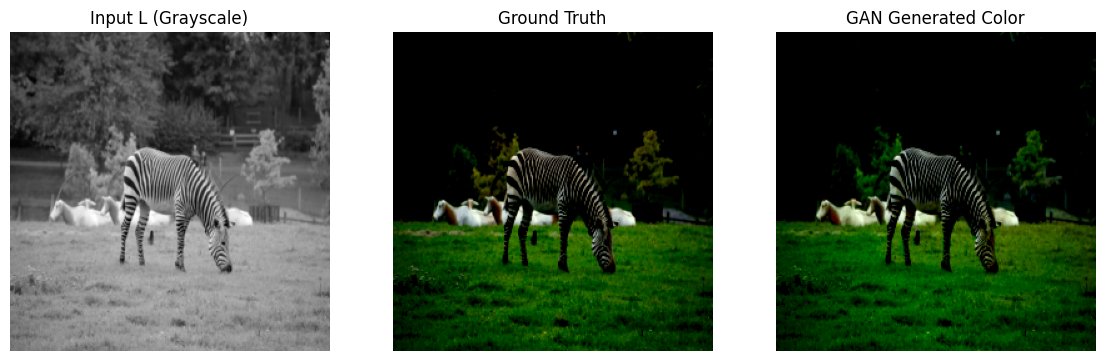

In [ ]:
visualize_gan_output(model, val_dataset, device, idx=11)
visualize_gan_output(model, val_dataset, device, idx=42)
visualize_gan_output(model, val_dataset, device, idx=999)
visualize_gan_output(model, val_dataset, device, idx=93)
visualize_gan_output(model, val_dataset, device, idx=909)
visualize_gan_output(model, val_dataset, device, idx=709)
visualize_gan_output(model, val_dataset, device, idx=528)
visualize_gan_output(model, val_dataset, device, idx=127)
visualize_gan_output(model, val_dataset, device, idx=169)
visualize_gan_output(model, val_dataset, device, idx=16)
visualize_gan_output(model, val_dataset, device, idx=36)
